# Classification task

In [2]:
# installation of packages
!pip install nltk

In [3]:
# installation of NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data pre-processing

In [4]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('dataset_filtered_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

df.head()

,Unnamed: 0,wiki_id,frbs_id,name,author,date,genres,summary
0,0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"['realistic fiction', ""children's literature"",...","Old Major, the old boar on the Manor Farm, cal..."
1,1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"['science fiction', 'humor']","Alex, a teenager living in near-future England..."
2,2,986,/m/0ldx,The Plague,Albert Camus,1947,['realistic fiction'],The text of The Plague is divided into five pa...
3,3,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"['science fiction', 'fantasy']",The novel posits that space around the Milky W...
4,4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"['historical', 'realistic fiction']","The book tells the story of Paul Bäumer, a Ger..."


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1
        

# splitting dataset in train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2023)

In [6]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower() for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)

In [7]:
X_train = vectorizer.fit_transform(X_train) # learning normalized TF-IDF weights
X_test = vectorizer.transform(X_test) # calculating TF-IDF weights


print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(8554, 2885) (2852, 2885)
(8554, 15) (2852, 15)


## Classifiers

### Multinomial Naive Bayes

In [8]:
from sklearn.naive_bayes import ComplementNB
from sklearn.multiclass import OneVsRestClassifier

# defining the model and fitting
base_twcnb = ComplementNB()
clf_twcnb = OneVsRestClassifier(base_twcnb)
clf_twcnb.fit(X_train, Y_train)

print(clf_twcnb.n_features_in_)

2885


### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Fitting the model
lr = LogisticRegression(max_iter=100, n_jobs=-1)    # L2 penalty term is the default choice
clf_lr = OneVsRestClassifier(lr)  

print(clf_lr.n_features_in_)

In [22]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime

start = datetime.now()

params = {
    'estimator__penalty' : ['l2','l1'],
    'estimator__solver' : ['liblinear','newton-cholesky','saga'],  # default lbfgs
    'estimator__C': [0.01,0.1,1,5,10]   
        }

lr_grid = GridSearchCV(clf_lr, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs=-1)
lr_grid.fit(X_train,Y_train)

print("Time taken to perform hyperparameter tuning: ", datetime.now()-start)
print("Tuned Hyperparameters :", lr_grid.best_params_)
print("Best estimator: ",lr_grid.best_estimator_)
print("Best Cross Validation Score: ", lr_grid.best_score_)

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\multiclass.py", line 337, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "C:\Users\User\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\User\anaconda3

Time taken to perform hyperparameter tuning:  0:14:40.691115
Tuned Hyperparameters : {'estimator__C': 5, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=5, n_jobs=-1, solver='saga'))
Best Cross Validation Score:  0.28396006575956745


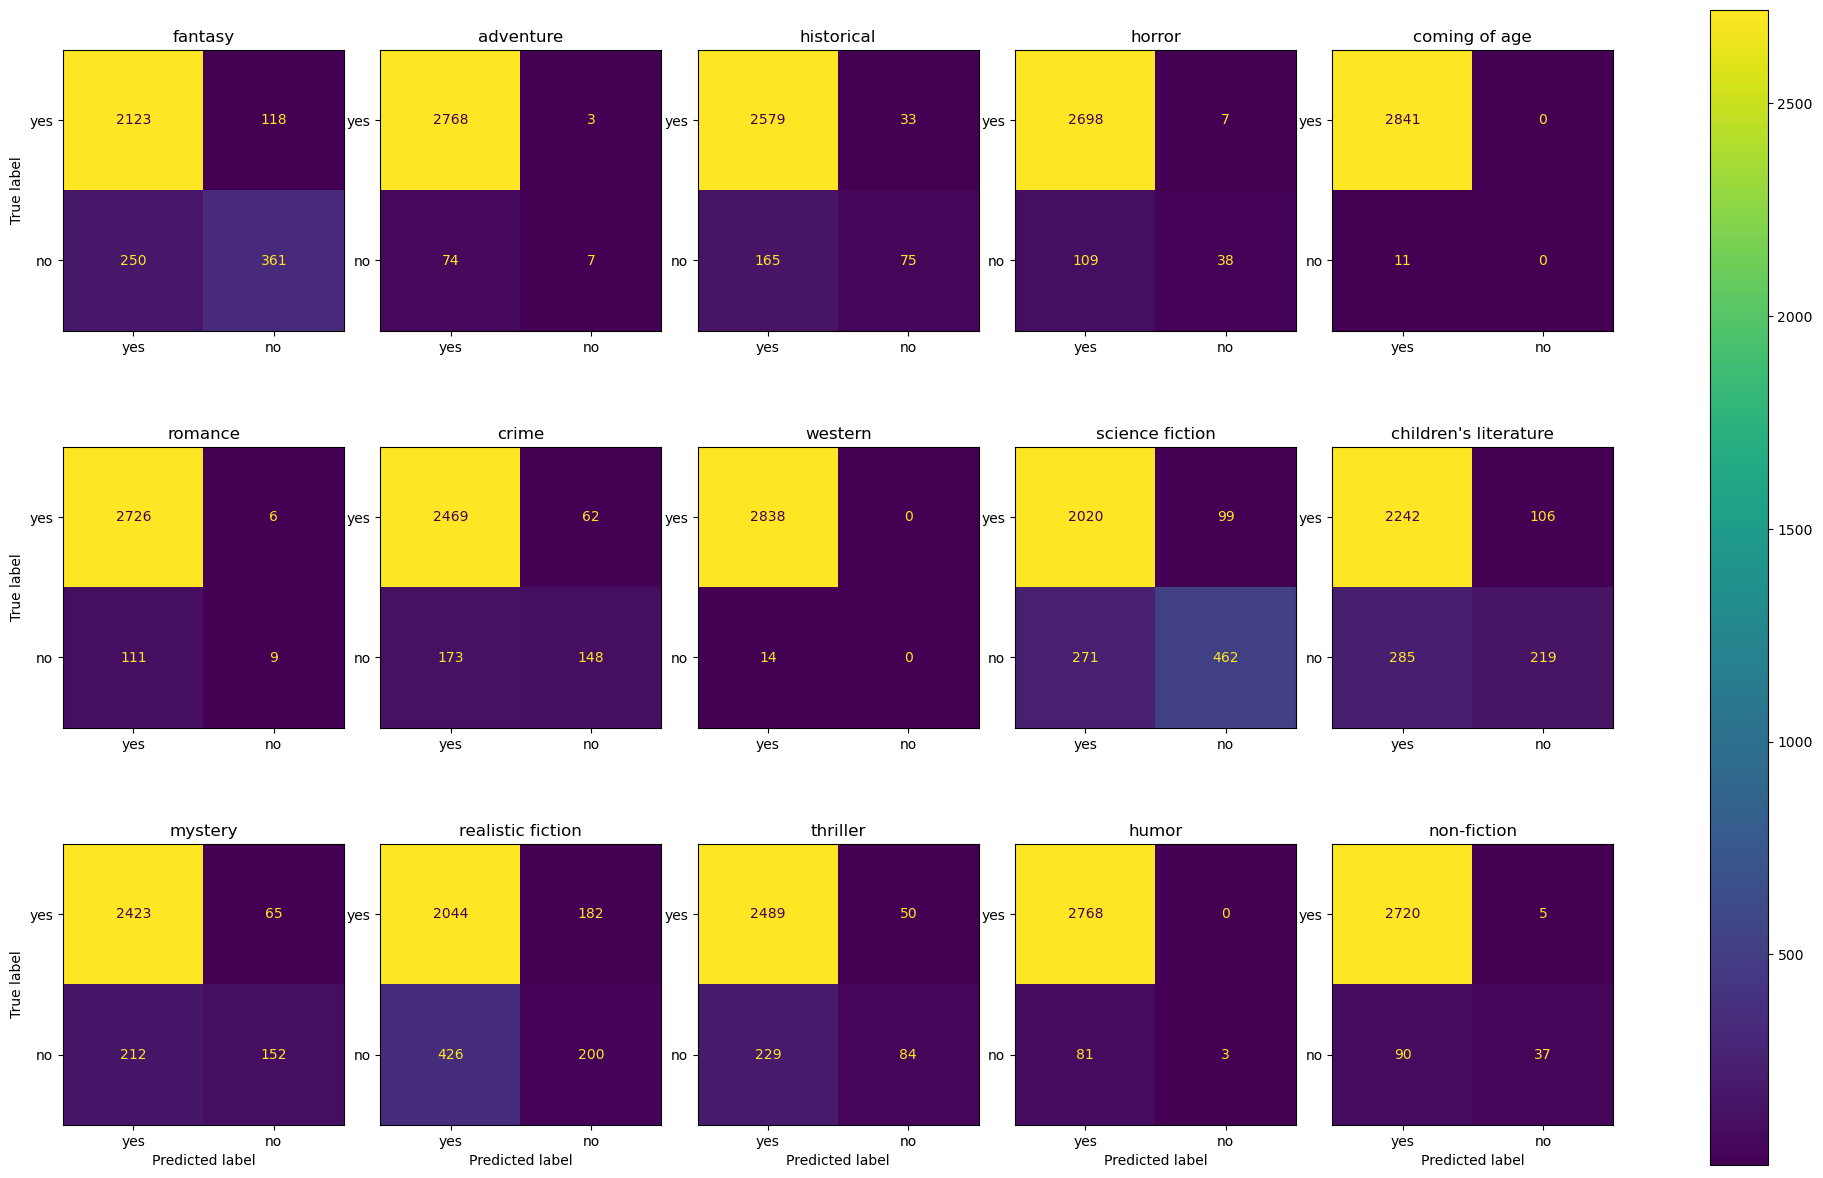

Accuracy : 0.296984572230014
Hamming loss  0.07566619915848527
Micro
	Precision:	 0.7092
	Recall:		 0.4178
	F1 score:	 0.5259
Macro
	Precision:	 0.6351
	Recall:		 0.2788
	F1 score:	 0.3586
Samples
	Precision:	 0.4993
	Recall:		 0.4534
	F1 score:	 0.4548

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.75      0.59      0.66       611
            adventure       0.70      0.09      0.15        81
           historical       0.69      0.31      0.43       240
               horror       0.84      0.26      0.40       147
        coming of age       0.00      0.00      0.00        11
              romance       0.60      0.07      0.13       120
                crime       0.70      0.46      0.56       321
              western       0.00      0.00      0.00        14
      science fiction       0.82      0.63      0.71       733
children's literature       0.67      0.43      0.53       504
              mystery       0

In [26]:
best_lr = lr_grid.best_estimator_
best_lr.fit(X_train, Y_train)
predictions = best_lr.predict(X_test)

compute_metrics(Y_test, predictions, genres)

In [28]:
# Dataframe showing all possible combination of parameters
# The last column shows ranks of the combinations
pd.DataFrame(lr_grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,param_estimator__penalty,param_estimator__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.629842,0.225080,0.019747,0.002034,0.01,l2,liblinear,"{'estimator__C': 0.01, 'estimator__penalty': '...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
1,0.032513,0.004019,0.000000,0.000000,0.01,l2,newton-cholesky,"{'estimator__C': 0.01, 'estimator__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
2,18.461042,1.277041,0.018351,0.001353,0.01,l2,saga,"{'estimator__C': 0.01, 'estimator__penalty': '...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
3,1.099061,0.099763,0.023338,0.005664,0.01,l1,liblinear,"{'estimator__C': 0.01, 'estimator__penalty': '...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
4,0.032313,0.003711,0.000000,0.000000,0.01,l1,newton-cholesky,"{'estimator__C': 0.01, 'estimator__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,24


In [38]:
# Classifier chain_1
from sklearn.metrics import accuracy_score
cc = ClassifierChain(lr,order='random', random_state=2023)
cc.fit(X_train,Y_train)
predictions_cc = cc.predict(X_test)
predictions_cc_prob = cc.predict_proba(X_test)    # Predict probability estimates.

print("Accuracy =",accuracy_score(Y_test,predictions_cc))
print(predictions_cc_prob)

Accuracy = 0.30995792426367463
[[0.32117961 0.01464366 0.02110952 ... 0.04061518 0.02829418 0.00727232]
 [0.34035756 0.01753542 0.02714472 ... 0.08618061 0.02273169 0.01755199]
 [0.57230378 0.02058608 0.18860993 ... 0.00996012 0.02095653 0.01840961]
 ...
 [0.46256653 0.01816124 0.05029058 ... 0.04237285 0.02463768 0.13189669]
 [0.14475312 0.02372693 0.24504841 ... 0.02765188 0.03601925 0.1141147 ]
 [0.45805152 0.02187487 0.03734382 ... 0.04048258 0.01959717 0.00577807]]


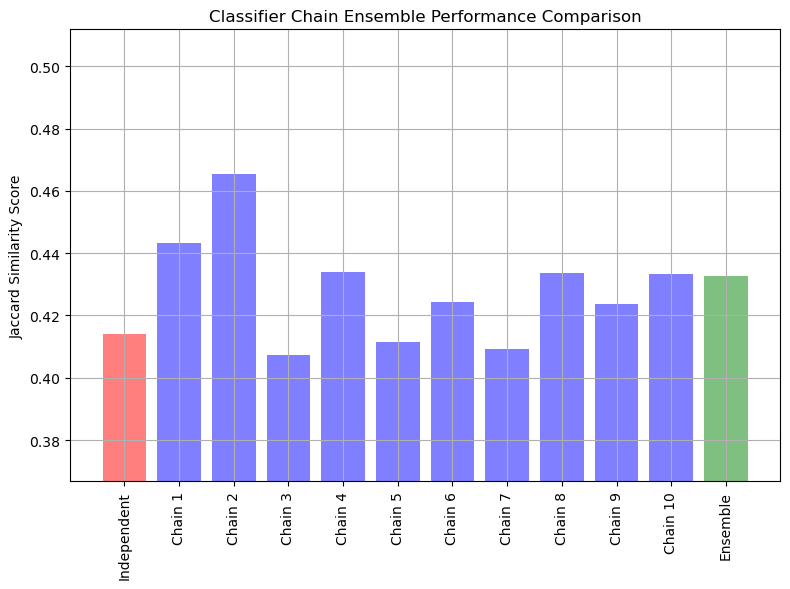

In [29]:
# Classifier chain_2 with the plot 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import jaccard_score


predictions = best_lr.predict(X_test)  
lr_jaccard_score = jaccard_score(Y_test,predictions, average='samples')

chains = [ClassifierChain(lr, order='random', random_state=i) for i in range(10)]
for chain in chains :
    chain.fit(X_train,Y_train)
    
Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])

chain_jaccard_scores = [
    jaccard_score(Y_test,Y_pred_chain>=0.5, average='samples') for Y_pred_chain in Y_pred_chains
]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test, Y_pred_ensemble >= 0.5, average="samples")

model_scores = [lr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for independent, all chains and the ensemble
fit,ax = plt.subplots(figsize=(8,6))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()


In [33]:
print(lr_jaccard_score)

0.414177185600748


In [31]:
print(chain_jaccard_scores)

[0.4433380084151473, 0.4653576437587658, 0.40745675549322113, 0.43382421692379614, 0.41157667134174847, 0.4243747078073866, 0.40910472183263213, 0.43374240299205236, 0.42360916316035524, 0.4334209911173446]


In [32]:
print(ensemble_jaccard_score)

0.43270219728845255


### Random forest classifier
Inherently supports mulitilabel classification

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from datetime import datetime
from scipy.stats import randint

In [20]:
"""
# Hyperparameter tuning using GridSearchCV
gs_start = datetime.now() 

param_grid = { 
    'n_estimators': [5, 100],
    'max_depth' : [100,200, 250],
    'bootstrap' : [True, False],
    'class_weight': ['balanced', None],
    'min_samples_split' : [2,5]
}

rf = RandomForestClassifier(n_jobs = -1)

gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1_micro')
gs_rf.fit(X_train, Y_train)

print("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)
print("Best estimator: ",gs_rf.best_estimator_)
print("Best Cross Validation Score: ",gs_rf.best_score_)
"""

'\n# Hyperparameter tuning using GridSearchCV\ngs_start = datetime.now() \n\nparam_grid = { \n    \'n_estimators\': [5, 100],\n    \'max_depth\' : [100,200, 250],\n    \'bootstrap\' : [True, False],\n    \'class_weight\': [\'balanced\', None],\n    \'min_samples_split\' : [2,5]\n}\n\nrf = RandomForestClassifier(n_jobs = -1)\n\ngs_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=\'f1_micro\')\ngs_rf.fit(X_train, Y_train)\n\nprint("Time taken to perform grid search hyperparameter tuning: ",datetime.now()-gs_start)\nprint("Best estimator: ",gs_rf.best_estimator_)\nprint("Best Cross Validation Score: ",gs_rf.best_score_)\n'

In [21]:
# Hyperparameter tuning using RandomizedSearchCV to speed up the computations

st=datetime.now() 

rs_space = {'max_depth':list(np.arange(10, 250, step=10)),
          'n_estimators':np.arange(2, 100, step=10),
          'max_features':randint(1,5),
          'criterion':['gini','entropy'],
          'min_samples_leaf':randint(1,4),
          'min_samples_split':np.arange(2, 10, step=2)}

from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(n_jobs = -1)
rsearcg_rf = RandomizedSearchCV(rf, rs_space, n_iter=50, scoring='f1_micro', n_jobs=-1, cv=5)
rsearcg_rf.fit(X_train,Y_train)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearcg_rf.best_estimator_)
print("Best Cross Validation Score: ",rsearcg_rf.best_score_)

# SEARCH RESULT : RandomForestClassifier(criterion='entropy', max_depth=200, max_features=4, min_samples_leaf=2, n_estimators=2, n_jobs=-1)

Time taken to perform hyperparameter tuning:  0:05:18.871458
Best estimator:  RandomForestClassifier(max_depth=170, max_features=3, min_samples_split=6,
                       n_estimators=2, n_jobs=-1)
Best Cross Validation Score:  0.1892539354975399


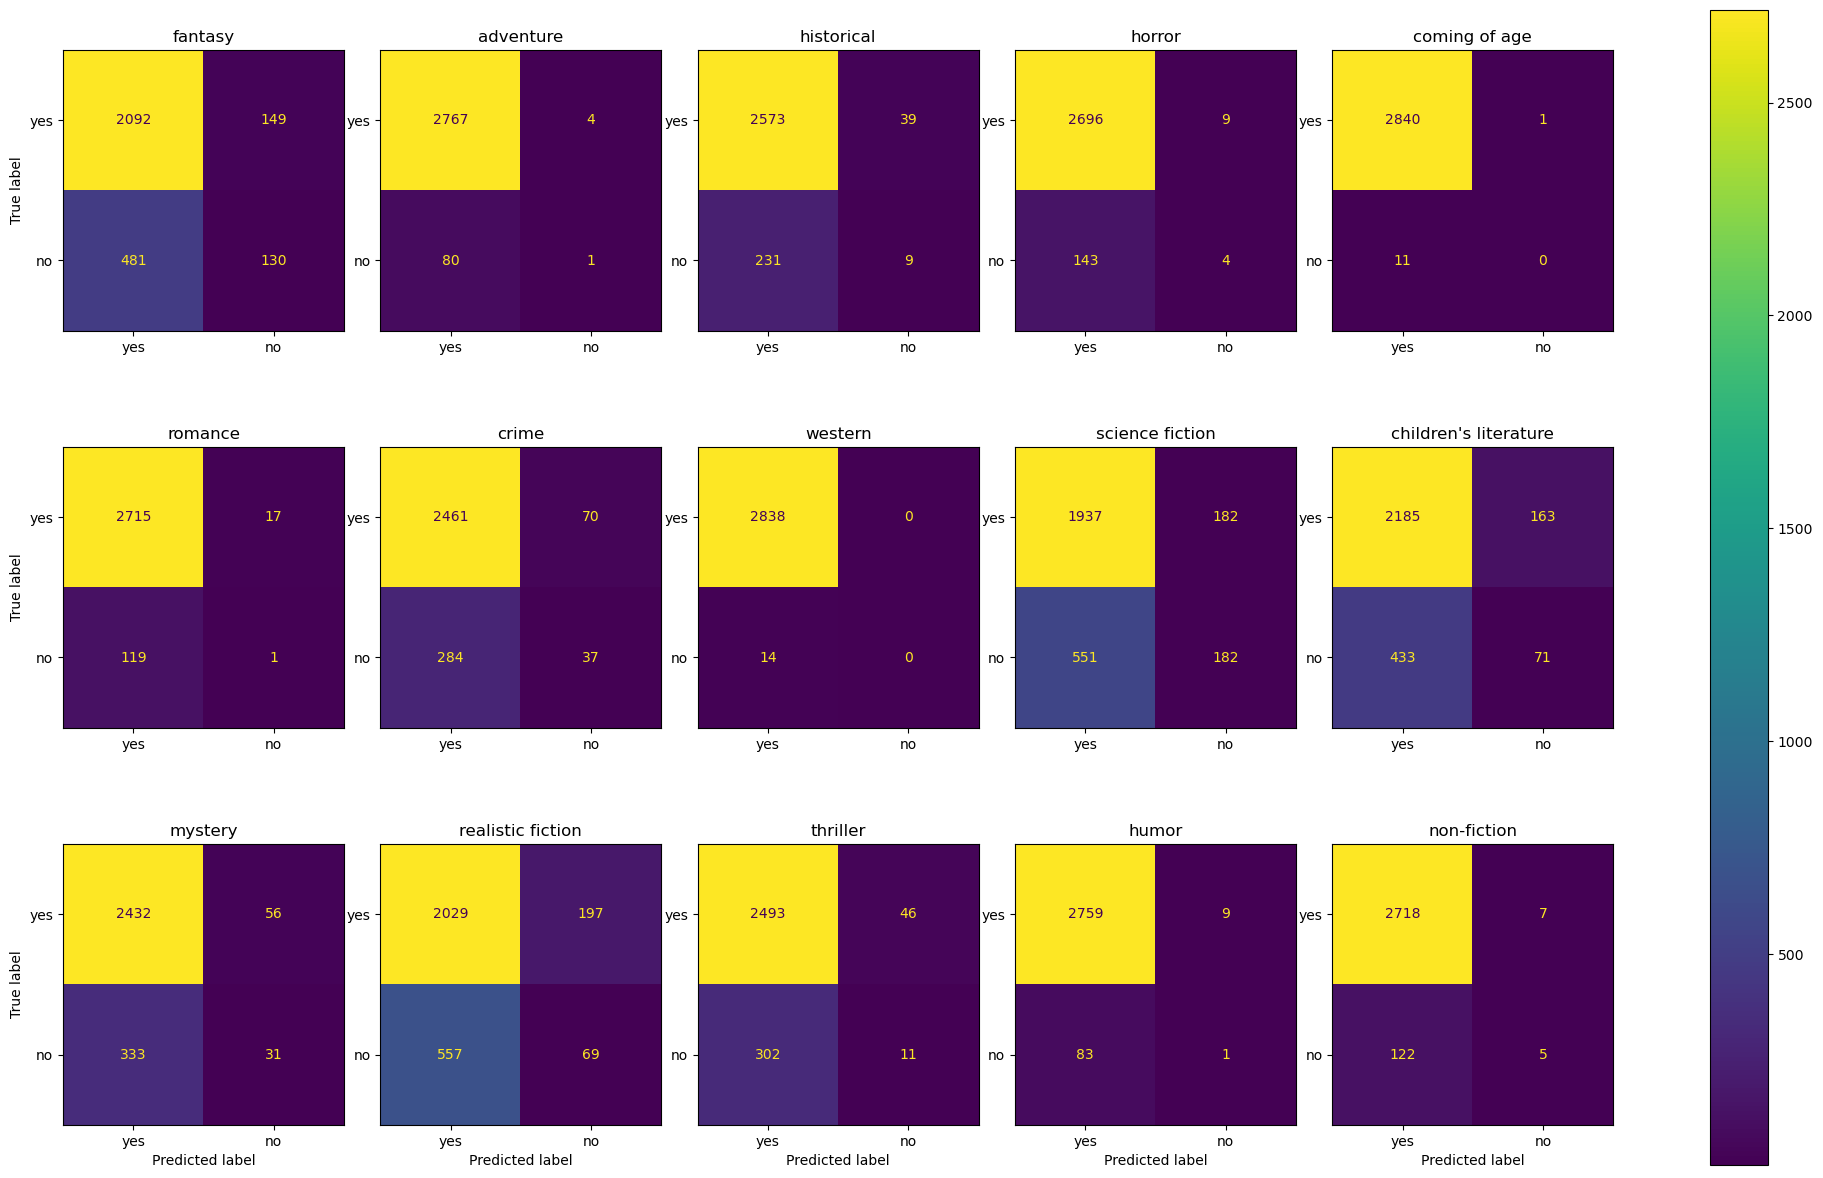

Accuracy : 0.08660589060308556
Hamming loss  0.10970079476390837
Micro
	Precision:	 0.3678
	Recall:		 0.1285
	F1 score:	 0.1904
Macro
	Precision:	 0.2461
	Recall:		 0.0723
	F1 score:	 0.1056
Samples
	Precision:	 0.1651
	Recall:		 0.1408
	F1 score:	 0.1437

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.47      0.21      0.29       611
            adventure       0.20      0.01      0.02        81
           historical       0.19      0.04      0.06       240
               horror       0.31      0.03      0.05       147
        coming of age       0.00      0.00      0.00        11
              romance       0.06      0.01      0.01       120
                crime       0.35      0.12      0.17       321
              western       0.00      0.00      0.00        14
      science fiction       0.50      0.25      0.33       733
children's literature       0.30      0.14      0.19       504
              mystery      

In [39]:
best_model = rsearcg_rf.best_estimator_
best_model.fit(X_train, Y_train)
predictions = best_model.predict(X_test)

compute_metrics(Y_test, predictions, genres)

### XGBoost

In [41]:
import xgboost as xgb
import numpy as np
"""
# experimantal version supports multilabel classification
clf = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.5, gamma = 0.1, seed = 2023, n_jobs = -1, 
                        n_estimators = 100)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_test,Y_pred))

from sklearn.metrics import f1_score
print(f1_score(Y_test, Y_pred, average=None))
"""

'\n# experimantal version supports multilabel classification\nclf = xgb.XGBClassifier(max_depth = 5, learning_rate = 0.5, gamma = 0.1, seed = 2023, n_jobs = -1, \n                        n_estimators = 100)\nclf.fit(X_train, Y_train)\nY_pred = clf.predict(X_test)\nprint(accuracy_score(Y_test,Y_pred))\n\nfrom sklearn.metrics import f1_score\nprint(f1_score(Y_test, Y_pred, average=None))\n'

In [42]:
# Hyperparamer tuning using GridSearchCV

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier


param_grid = {
             'estimator__max_depth':[4,5,6],
             #'min_child_weight':[1,2],
             'estimator__learning_rate':[0.05, 0.1, 0.5],
             'estimator__gamma':[i/10.0 for i in range(0,5)],
             #'subsample':[0.5, 0.7],
             #'colsample_bytree':[0.5, 0.7]
             }

model = xgb.XGBClassifier(objective = 'binary:logistic', 
                         n_estimators = 200,            # set initial relatively high number of boosting rounds,
                                                        # and opmtimize it later using XGBoost's cv method
                         seed = 2023,  
                         use_label_encoder = False,
                         num_class=2,
                          n_jobs = -1
                         ) 



one_vs_rest_xgboost = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1))

model_tunning = GridSearchCV(one_vs_rest_xgboost, param_grid=param_grid,
                             scoring ='f1_samples')

model_tunning.fit(X_train, Y_train)
print(model_tunning.best_score_)
print(model_tunning.best_params_)
Y_pred_xgboost = model_tunning.predict(X_test)

from sklearn.metrics import f1_score
f1_score(Y_test, Y_pred_xgboost, average=None)

# SEARCH RESULT {'estimator__gamma': 0.1, 'estimator__learning_rate': 0.5, 'estimator__max_depth': 5}

C:\Users\User\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


KeyboardInterrupt: 

In [43]:
gs_xgboost = model_tunning.best_estimator_
gs_xgboost.fit(X_train, Y_train)
predictions = gs_xgboost.predict(X_test)

compute_metrics(Y_test, predictions, genres)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

## Evaluation

In [44]:
def compute_metrics(Y_test, predictions, target_names):
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    hamming_loss, classification_report, confusion_matrix, ConfusionMatrixDisplay
    
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    start = datetime.now()

    #______________________________CONFUSTION MATRICES______________________________________________
    
    #print(multilabel_confusion_matrix(y_true = Y_test, y_pred = predictions), labels = target_names)
    f, axes = plt.subplots(3, 5, figsize=(25, 15))
    axes = axes.ravel()
    for i in range(Y_test.shape[1]):
        disp = ConfusionMatrixDisplay(confusion_matrix(Y_test[:, i], predictions[:, i]),
                                      display_labels=["yes","no"])
        disp.plot(ax=axes[i], values_format='.4g')
        disp.ax_.set_title(f'{target_names[i]}')
        if i<10: disp.ax_.set_xlabel('')
        if i%5!=0: disp.ax_.set_ylabel('')
        disp.im_.colorbar.remove()

    plt.subplots_adjust(wspace=0.13, hspace=0.1)
    f.colorbar(disp.im_, ax=axes)
    plt.show()
    
    #______________________________ACC, HL, MICRO, MACRO AND SAMPLES________________________________
    print("Accuracy :",accuracy_score(Y_test, predictions))
    print("Hamming loss ",hamming_loss(Y_test,predictions))
    
    for avg in ['micro', 'macro', 'samples']:
        print(avg[0].upper() + avg[1:])
        print(f"\tPrecision:\t{precision_score(Y_test, predictions, average=avg, zero_division=0): .4f}")
        print(f"\tRecall:\t\t{recall_score(Y_test, predictions, average=avg, zero_division=0): .4f}")
        print(f"\tF1 score:\t{f1_score(Y_test, predictions, average=avg, zero_division=0): .4f}")

    #______________________________CLASSIFICATION REPORT____________________________________________
    print("\nClassification Report")
    print (classification_report(y_true = Y_test, y_pred = predictions, target_names = target_names, zero_division=0))
    print("Time taken to run this cell :", datetime.now() - start)

OneVsRest + Transformed Weignt-normalized Complement Naive Bayes


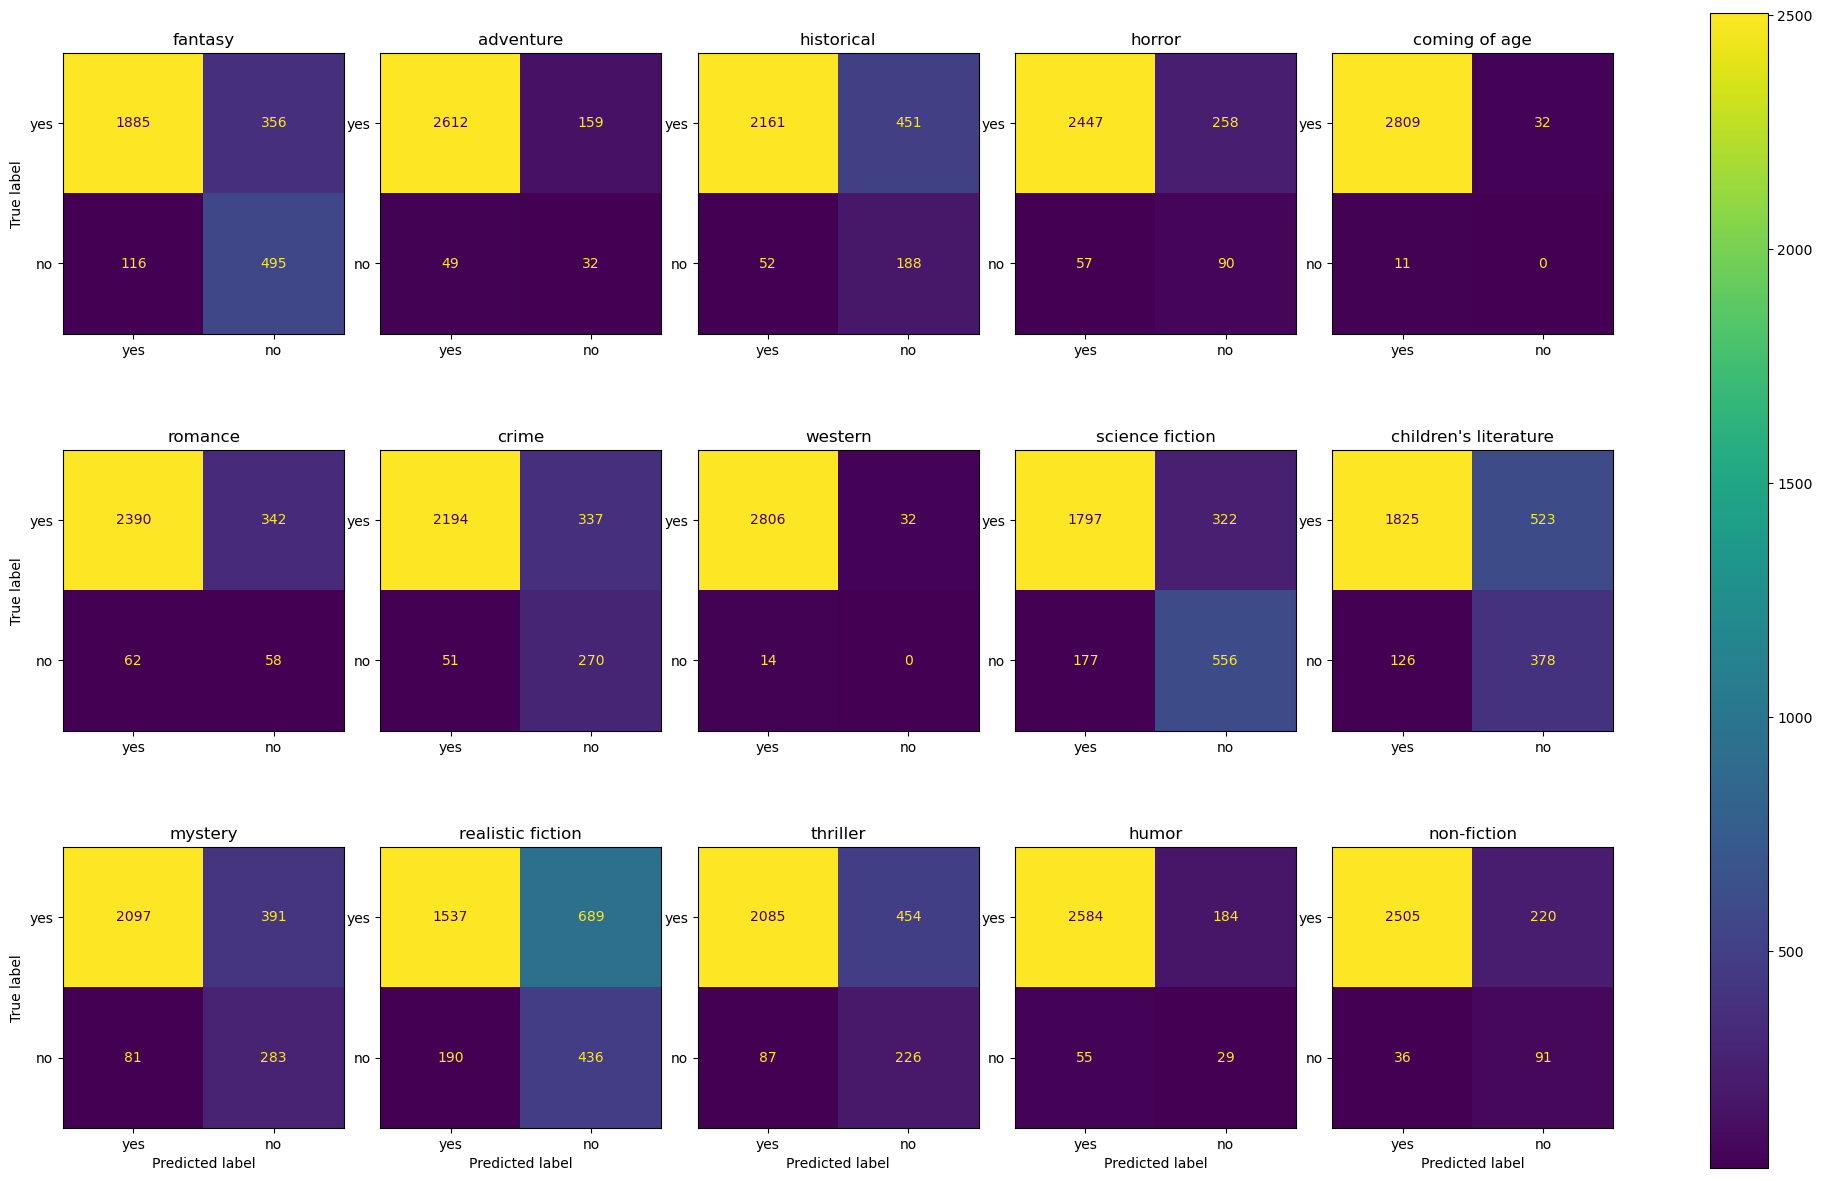

Accuracy : 0.15252454417952313
Hamming loss  0.13824216923796168
Micro
	Precision:	 0.3974
	Recall:		 0.7291
	F1 score:	 0.5144
Macro
	Precision:	 0.3009
	Recall:		 0.5794
	F1 score:	 0.3898
Samples
	Precision:	 0.4706
	Recall:		 0.7644
	F1 score:	 0.5359

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.58      0.81      0.68       611
            adventure       0.17      0.40      0.24        81
           historical       0.29      0.78      0.43       240
               horror       0.26      0.61      0.36       147
        coming of age       0.00      0.00      0.00        11
              romance       0.14      0.48      0.22       120
                crime       0.44      0.84      0.58       321
              western       0.00      0.00      0.00        14
      science fiction       0.63      0.76      0.69       733
children's literature       0.42      0.75      0.54       504
              mystery      

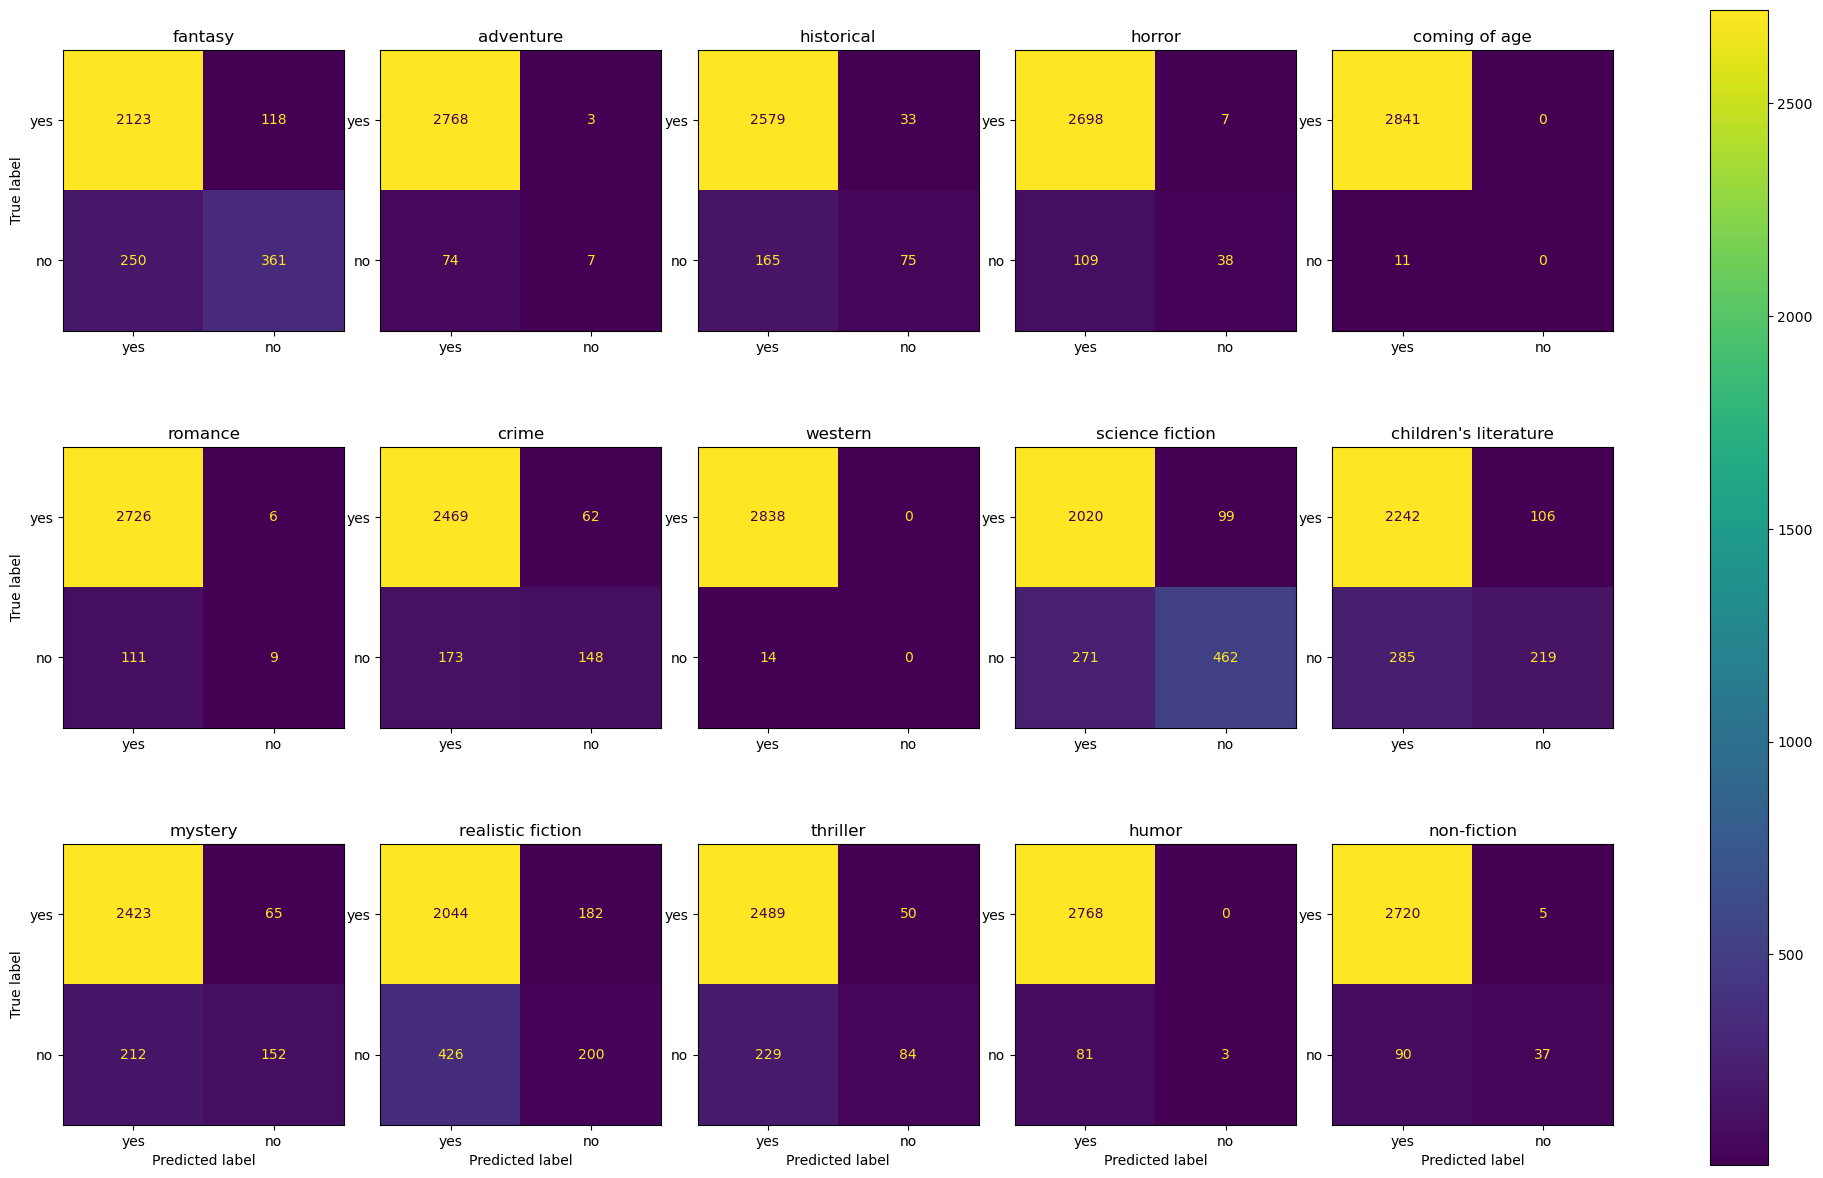

Accuracy : 0.296984572230014
Hamming loss  0.07566619915848527
Micro
	Precision:	 0.7092
	Recall:		 0.4178
	F1 score:	 0.5259
Macro
	Precision:	 0.6351
	Recall:		 0.2788
	F1 score:	 0.3586
Samples
	Precision:	 0.4993
	Recall:		 0.4534
	F1 score:	 0.4548

Classification Report
                       precision    recall  f1-score   support

              fantasy       0.75      0.59      0.66       611
            adventure       0.70      0.09      0.15        81
           historical       0.69      0.31      0.43       240
               horror       0.84      0.26      0.40       147
        coming of age       0.00      0.00      0.00        11
              romance       0.60      0.07      0.13       120
                crime       0.70      0.46      0.56       321
              western       0.00      0.00      0.00        14
      science fiction       0.82      0.63      0.71       733
children's literature       0.67      0.43      0.53       504
              mystery       0

In [46]:
print('OneVsRest + Transformed Weignt-normalized Complement Naive Bayes')
predictions = clf_twcnb.predict(X_test)
compute_metrics(Y_test, predictions, genres)

print('\nOneVsRest + Logistic regression') 
predictions = best_lr.predict(X_test)
compute_metrics(Y_test, predictions, genres) 

In [ ]:
# coming of age, western -> remove
# huomor adventure -> low score
# romance horror 